# Model interpretability: how is it affected by imbalance?

In numerous data science applications, it's important not only to get a correct prediction but also a comprehensive explanation of the inference process. This lends credibility to the model, making us comfortable in its use and ensuring that we are not "overfitting" on elements that are not relevant to the problem at hand.

There are several different approaches to interpretability. In particular, one of the categorizations is splitting the methods between global explanations and local explanations. At a high level, a local explanation of a model is concerned with describing the reasoning behind a prediction (for example, LIME), while a global explanation attempts to describe the model's behavior in completeness (such as using surrogate models with shallow decision trees).

## Feature importances

Tree-based algorithms, during training, naturally build a list of relevant variables. This happens due to their greedy strategy of making the best possible split, with the best possible variable, at any given moment (according to some criterion, usually related to the purity of the created leaves in the case of classification). Poorly discriminating variables are used much less than the variables that help to make the prediction. This process naturally derives measures of importance for variables such as the number of times it is used or a weighting of the information gained during the choice of tree splits.

As tree-based models empirically tend to perform well, it's usual to analyze the [`.feature_importances`](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) attribute of models to see which variables are relevant to the model we are auditing.

## SHAP

The current state of the art for model interpretation is [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations). It is model-agnostic (that is, it can be used with any model), which is very useful and has an elegant high-level understanding. Its main idea is to decompose the final forecast of a given instance into factors associated with each of its variables. To do this, it compares what the forecast would be for that model if a specific variable were not available and sees the delta we get when we add it up. This process is not trivial since the order of withdrawal influences the deltas. Also, it's not obvious what a model that doesn't have a subset of the variables means (should we retrain it?). SHAP has some inferences trying to get around these problems. It works really well and is the most used methodology on the market for explainability today.

Mathematically, SHAP generates, for each instance, a value for each variable so that the sum of these individual contributions is equivalent to the value predicted by the model, that is,

$$ f(x_i) = \phi_0 + \sum_{j=1}^d \phi_j(x_i), $$

where $f$ is our model, $x_i$ is the instance we are trying to understand, $d$ is the number of features, $\phi_j(x_i)$ is the contribution for feature $j$ for the observation $x_i$, and $\phi_0 \propto \frac{1}{N}\sum_{i=1}^N y_i$ is a kind of prior, related to the average of the target in our dataset.

SHAP is a local explanation algorithm, as should have become clear since we are calculating the prediction contributions of an instance $x_i$, but it allows a global explanation similar to what `.feature_importances_` represents for a tree-based algorithm model: if we group (as the average) the absolute values of the SHAPs of each variable, that is, $\bar{\phi_j} = \frac{1}{N} \sum_{i=1}^N |\phi_j(x_i)|$ we get the average contribution per feature. This interpretation allows us to see, on average, what impact a given variable has on decision-making power.

It is important to note that, usually, for a binary classification problem, the SHAP scale is in log-odds (so if your dataset has a ratio of 0.5-0.5, then $\phi_0 = 0$). But it is possible, in recent versions of `shap`, to put the SHAP scale in probability.

___

In this notebook, we will discuss the use of variable importance methods (mainly using the technique of grouping the SHAPs of a given column by the average of the absolute values) when we have a class imbalance. The idea is to see where we should be careful when interpreting the results and when we can use the usual habits without class imbalance-related problems.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

import shap

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

C:\Users\Carlo\anaconda3\envs\shapimblearn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this experiment, we are creating a dataset using [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification) and, modifying the imbalance, we track how the different ways of calculating `.feature_importances` are affected (we are always using the same algorithm, a [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). We will be using 4 different types of `feature_importances_` calculations:

1. Usual gain feature importance from sklearn;
2. Aggregating  SHAP by mean of absolute value (as discussed above);
3. Aggregating  SHAP by mean of absolute value but restricted to `y==1` samples;
4. Aggregating  SHAP by mean of absolute value but normalizing for the sum to add to 1.

Note that, in the code, when `n_samples` is fixed, as we vary the imbalance we are not generating new rounds of [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification) with different `weights`, we are explicitly throwing out samples from the original dataset to create the imbalance, so the variables should continue to have the same importance.

In [2]:
from experiments import plot, undersample

def experiment(n_samples, alphas, estimator, bootstrap=10):
    X, y = \
    make_classification(n_samples=n_samples,
                        n_features=20,
                        n_informative=6,
                        n_redundant=4,
                        shuffle=False,
                        random_state=42
                       )
    # 10 first variables are usefull of 20 in total

    feat_imp = defaultdict(list)
    for alpha in tqdm(alphas):
        X_under, y_under = undersample(X, y, alpha)
        X_train, X_test, y_train, y_test = train_test_split(X_under, y_under,
                                                            stratify=y_under,
                                                            random_state=42,
                                                            test_size=0.25)
        # Bootstraping for confidence intervals
        for j in range(bootstrap):
            model = estimator(random_state=j).fit(X_train, y_train)
            feat_imp['alpha'].append(alpha)
            feat_imp['imp'].append(model.feature_importances_)
            feat_imp['performance'].append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

    return (agregate_dataframe(feat_imp, 'imp', bootstrap, X, alphas),
            agregate_dataframe(feat_imp, 'performance', bootstrap, X, alphas, True))

In [3]:
def agregate_dataframe(feat_imp, col, bootstrap, X, alphas, performance=False):
    
    if performance:
        columns = ['ROCAUC']
    else:
        columns = [f"column_{i+1}" for i in range(X.shape[1])]
    
    df = \
    (pd.DataFrame(feat_imp[col],
                  index=np.array([bootstrap*[val] for val in alphas]).flatten(),
                  columns=columns)
     .reset_index())

    df_group = df.groupby(by='index').agg({col: [np.mean, np.std] for col in columns})
    df_group.columns = ['_'.join(col) for col in df_group.columns]
    
    return df_group

In [4]:
n_samples_list = [2000, 5000, 10000, 20000]
alphas = [0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1.0]

## 1. Usual feature importance Random Forest

First, let's evaluate the usual way of calculating `.feature_importances`.

In [7]:
estimator = RandomForestClassifier

df_groups_feat_imp = []
for j, n_samples in enumerate(n_samples_list):
    df_group_imp, df_group_performance = experiment(n_samples, alphas, estimator, 10)
    df_groups_feat_imp.append((df_group_imp, df_group_performance))

100%|██████████| 10/10 [09:15<00:00, 55.52s/it]


Here, we define `alpha` as "the number of instances of the minority class" over "the number of instances of the majority class". In the plot below we see that when `alpha` is close to 1, all models, even those with smaller `n_samples`, have reasonable performance. When we change `alpha` to values closer to 0 (note that the x-axis is in log scale), then the model starts to have worse performance and gets confused, mixing the `.feature_importances` of the bad variables (in orange) with the useful variables (in blue). This effect is increasingly worse as we reduce the total samples we have in the dataset. This demonstrates that, here, _absolute imbalance_ leads us to a more serious problem than _relative imbalance_.

In [ ]:
plot(df_groups_feat_imp, alphas, n_samples_list, logy=False)

![fig1](../images/interp/fig1.png)

## 2. SHAP importance Random Forest

When aggregating SHAP, we have a problem: the proportion between the classes is no longer equal, so $\phi_0 \propto \frac{1}{N}\sum_{i=1}^N y_i \approx 0$ (in log-odds, as we shrink `alpha`, $\phi_0$ grows to larger and larger negative values). We'll see the impact this has on the plot.

In [10]:
from utils import SHAPImportanceRandomForestClassifier

estimator = SHAPImportanceRandomForestClassifier

df_groups_shap = []
for j, n_samples in enumerate(n_samples_list):
    df_group_imp, df_group_performance = experiment(n_samples, alphas, estimator, 4)
    df_groups_shap.append((df_group_imp, df_group_performance))

100%|██████████| 10/10 [3:00:00<00:00, 1080.07s/it]


Here, the amounts fall close to zero, regardless of the number of samples we have. This problem occurs because since $\phi_0$ is close to the prediction of the majority class, then the values of $\phi_j(x_i)$ for the majority class instances do not need to be large for the sum to remain close to $\phi_0$. When we group on average, as these samples are the majority (if our model has a minimally reasonable performance) they push the value of $\bar{\phi_j}$ close to zero.

In [ ]:
plot(df_groups_shap, alphas, n_samples_list, logy=False)

![fig1](../images/interp/fig2.png)

## 3. SHAP[y==1] importance Random Forest

One of the ways to try to get around this is to calculate a different version of $\bar{\phi_j}$, such as, for example, averaging only the samples where the target is from the minority class.

This idea of analyzing aggregate SHAP into subgroups is very useful and gives interesting insights that are halfway between global and local explanations, that is, you see globally what happens in a region of your feature space. A very interesting article on the subject is the post [You are underutilizing SHAP values: understanding populations and events
](https://towardsdatascience.com/you-are-underutilizing-shap-values-understanding-populations-and-events-7f4a45202d5) by Estevão Uyrá, a former DataLab data scientist.

In [12]:
from utils import SHAP1ImportanceRandomForestClassifier

estimator = SHAP1ImportanceRandomForestClassifier

df_groups_shap1 = []
for j, n_samples in enumerate(n_samples_list):
    df_group_imp, df_group_performance = experiment(n_samples, alphas, estimator, 4)
    df_groups_shap1.append((df_group_imp, df_group_performance))

100%|██████████| 10/10 [1:04:58<00:00, 389.81s/it]


Here we see that the effect is more or less similar to what we have for the usual `.feature_importances_` from `RandomForest`, with absolute imbalance playing a more important role than relative imbalance.

In [ ]:
plot(df_groups_shap1, alphas, n_samples_list, logy=False)

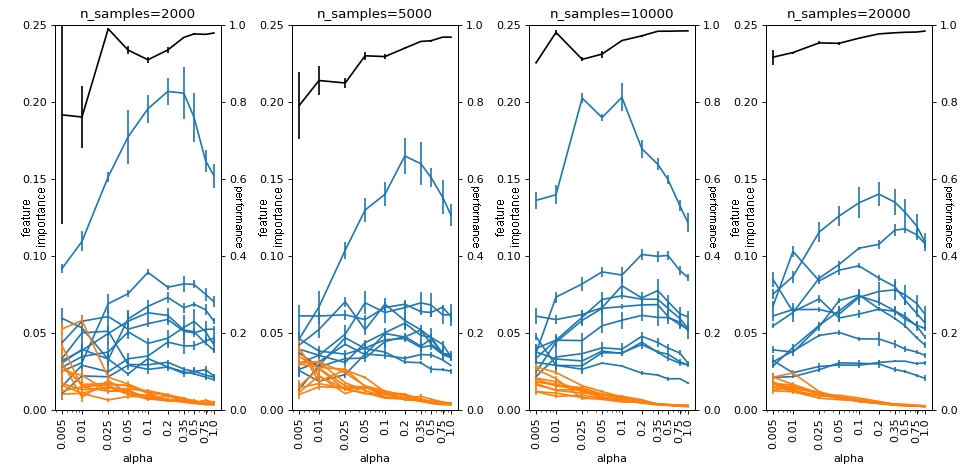

## 4. SHAP importance normalization Random Forest

The `.feature_importances_` of a [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) actually has a normalization at the end that makes `.feature_importances_.sum() == 1`. This idea can be applied to SHAP as well.

In [14]:
from utils import SHAPNormalizationImportanceRandomForestClassifier

estimator = SHAPNormalizationImportanceRandomForestClassifier

df_groups_shap_norm = []
for j, n_samples in enumerate(n_samples_list):
    df_group_imp, df_group_performance = experiment(n_samples, alphas, estimator, 4)
    df_groups_shap_norm.append((df_group_imp, df_group_performance))

100%|██████████| 10/10 [3:00:07<00:00, 1080.72s/it]


With this normalization, we see that SHAP behaves similarly to how the usual `feature_importances_` behaves. Separating useful variables (blue) from useless variables (orange) reasonably well and being affected by absolute imbalance, but dealing well with relative imbalance (eg when `n_samples=20000`).

In [ ]:
plot(df_groups_shap_norm, alphas, n_samples_list, logy=False)

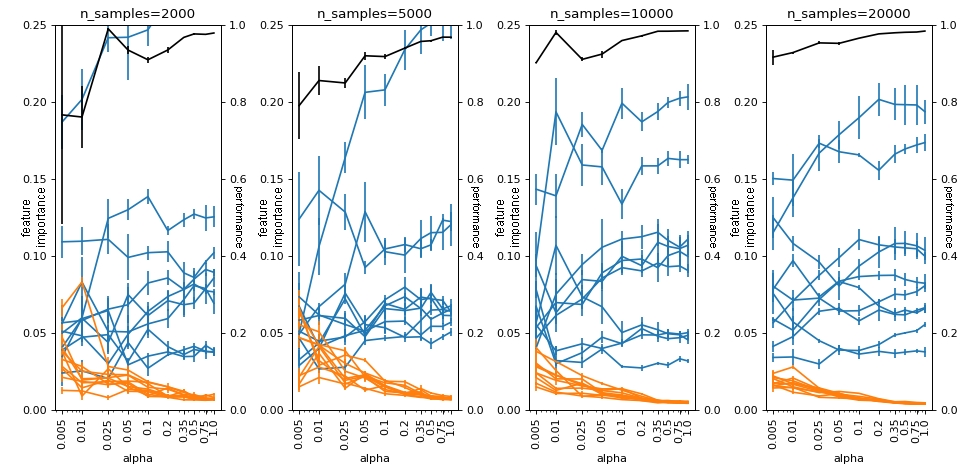

___

# Conclusion

We have seen that the methods of variable importance presented are more impacted with the absolute imbalance than with the relative imbalance, except for the "purest" SHAP. This occurred because the variation of $\phi_0$ as we change the relative imbalance has a significant impact on the values that the SHAPs assume, due to the additive interpretation of their sum being the result of the forecast. It is important to note, however, that despite the values in these cases being on a bad scale, we still have a good ordering that was evidenced by the last use of SHAP, from the simple normalization.

You should keep using SHAP importances. It shines when absolute imbalance is not a problem: comparing the `n_samples=20000` example we can see that SHAP importances divides the good features from the bad while the usual feature importance method from sklearn can get confused. You should pay attention to the scale, but as we saw, a simple normalization can solve to problem. Nonetheless, the usual feature importance is decent so if you are concerned with computational time, you don't lose a lot by using it.

___

# References

- [1] SHAP library: https://github.com/slundberg/shap

- [2] You are underutilizing SHAP values: understanding populations and events: https://towardsdatascience.com/you-are-underutilizing-shap-values-understanding-populations-and-events-7f4a45202d5

___

Comentários para melhorar esse notebook:

- Colocar o nome no eixo dos gráficos.

- Fica legal calcular cada um dos `.feature_importances_` num classificador diferente, mas fica muito inificiente calcular o SHAP tantas vezes diferentes. Note que o SHAP normalizado é literalmente o mesmo do anterior, mas eu calculei de novo.

- Ficaria mais legal ainda se, mesmo com os `n_samples` diferentes, o dataset fosse "o mesmo". Imagino que as curvas ficariam mais parecidas de um `n_samples` pro outro. Da pra fazer isso gerando apenas um `make_classification` grande e fazendo `.sample` dele para os `n_samples` menores.

- Vale adicionar um com o type='count' só pra ver.

- Fazer pra boosting.

In [ ]:
# from lightgbm import LGBMClassifier

# def GainLGBMClassifier(**params):
#     return LGBMClassifier(importance_type='gain', **params)

# funciona passar isso como estimator, 
# mas ele não faz a normalização do feat_imp_
# igual um RF e daí tá explodindo a escala.
# por isso não usei, mas daria.